In [154]:
import pandas as pd 
import numpy as np
import re
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### 1. Missing data

In [156]:
missing = df.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

Không có dữ liệu khuyết

### 2. Special Character

In [157]:
for column in df.select_dtypes(exclude='number').columns:
    special_chars = set()
    for value in df[column].unique():
        special_chars.update(re.findall(r'[^a-zA-Z0-9]', value))
    print(f"{column}: {list(special_chars)}")

Attrition: []
BusinessTravel: ['_', '-']
Department: ['&', ' ']
EducationField: [' ']
Gender: []
JobRole: [' ']
MaritalStatus: []
Over18: []
OverTime: []


In [158]:
df['Department'].unique()

array(['Sales', 'Research & Development', 'Human Resources'], dtype=object)

### 3. Feature value range

In [159]:
for column in df.select_dtypes(include='number').columns:
    print(f"{column}: [{df[column].min()}, {df[column].max()}]")
    # print('-'*50)

Age: [18, 60]
DailyRate: [102, 1499]
DistanceFromHome: [1, 29]
Education: [1, 5]
EmployeeCount: [1, 1]
EmployeeNumber: [1, 2068]
EnvironmentSatisfaction: [1, 4]
HourlyRate: [30, 100]
JobInvolvement: [1, 4]
JobLevel: [1, 5]
JobSatisfaction: [1, 4]
MonthlyIncome: [1009, 19999]
MonthlyRate: [2094, 26999]
NumCompaniesWorked: [0, 9]
PercentSalaryHike: [11, 25]
PerformanceRating: [3, 4]
RelationshipSatisfaction: [1, 4]
StandardHours: [80, 80]
StockOptionLevel: [0, 3]
TotalWorkingYears: [0, 40]
TrainingTimesLastYear: [0, 6]
WorkLifeBalance: [1, 4]
YearsAtCompany: [0, 40]
YearsInCurrentRole: [0, 18]
YearsSinceLastPromotion: [0, 15]
YearsWithCurrManager: [0, 17]


### 4. Outlier removal

Trước hết, ta xem lại phân phối dữ liệu

In [160]:
distr_col = ['Age', 'DailyRate', 'DistanceFromHome','HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 
       'TotalWorkingYears', 'TrainingTimesLastYear','YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager']

len(distr_col)

14

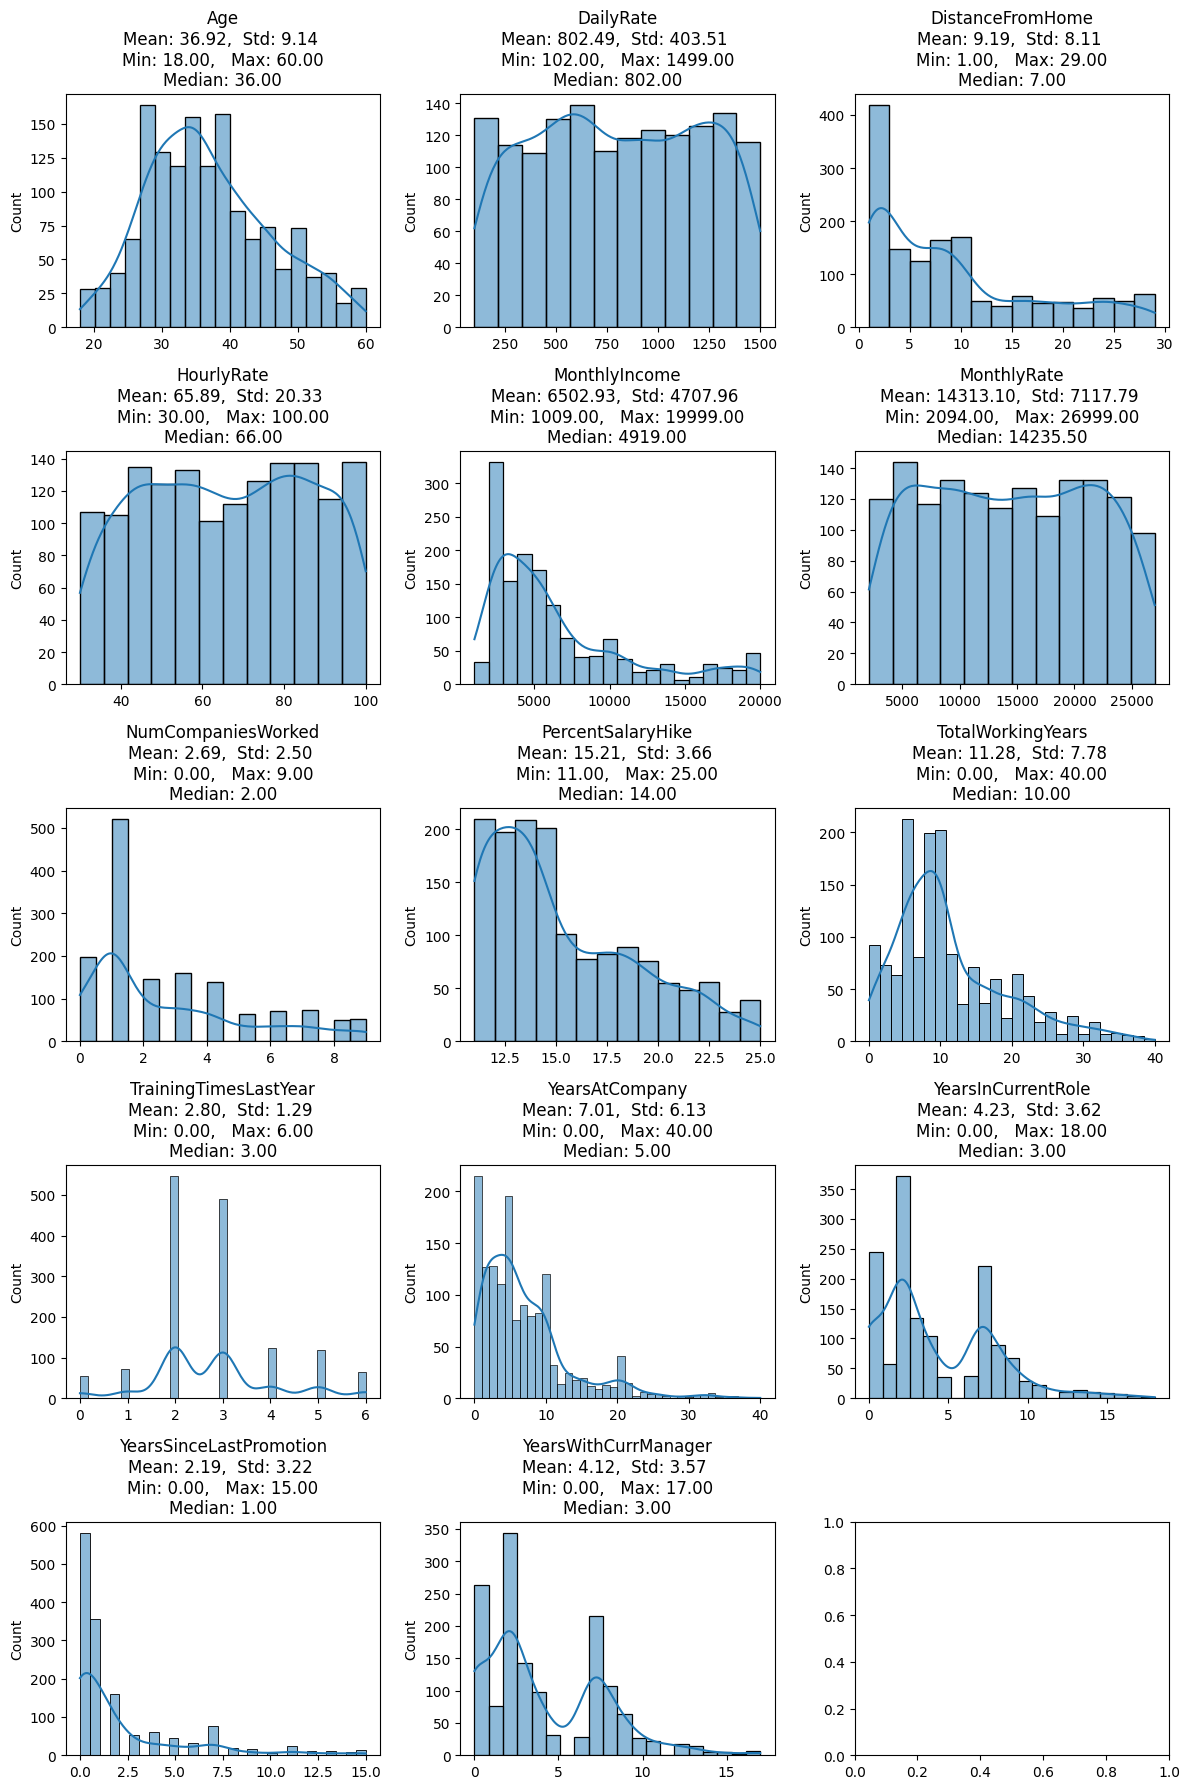

In [161]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 18)) 

for i, ax in enumerate(axes.flat):  
    if i < 14:
        sns.histplot(data=df[distr_col[i]],
                    kde=True, ax=ax)
        ax.set_title(f'{distr_col[i]}\n'
                    f'Mean: {df[distr_col[i]].mean():.2f},  Std: {df[distr_col[i]].std():.2f} \n'
                    f'Min: {df[distr_col[i]].min():.2f},   Max: {df[distr_col[i]].max():.2f}\n' 
                    f'Median: {df[distr_col[i]].median():.2f}')
        ax.set_xlabel('')
    
plt.tight_layout() 
plt.show()


Q-Q plot

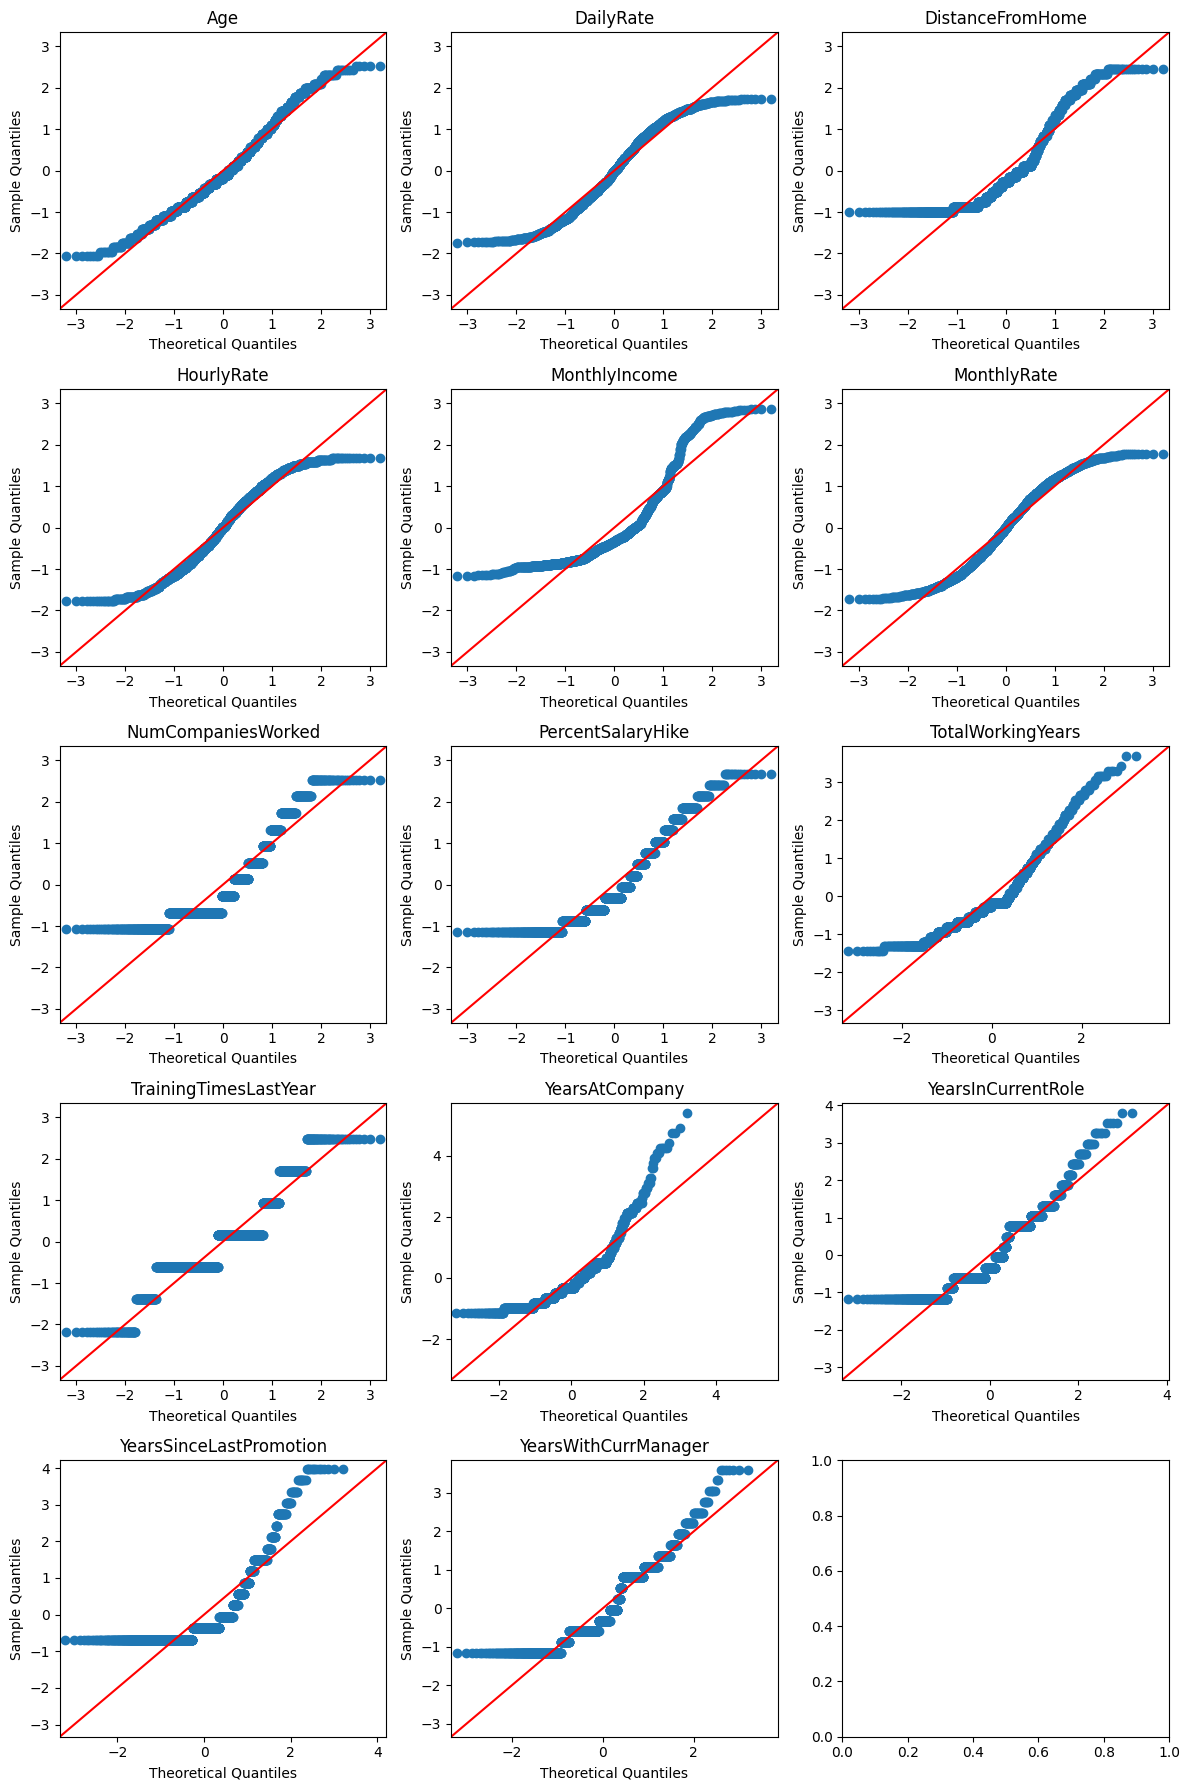

In [162]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 18))

for i, ax in enumerate(axes.flat):  
    if i < len(distr_col):  
        sm.qqplot(df[distr_col[i]], line='45', fit=True, dist=stats.norm, ax=ax)
        ax.set_title(distr_col[i]) 

plt.tight_layout()  
plt.show()


* Chỉ có biến số tuổi gần với phân phối chuẩn --> Z-score

* HourlyRate, DailyRate và MonthlyRate gần với phân phối đều --> IQR

* Một số biến lệch phải như DistanceFromHome, MonthlyIncome, PercentSalaryHike, YearsAtCompany, TotalWorkingYear, YearsSinceLastPromotion --> IQR

* Các biến còn lại --> Percentile

Treating Outliers:

https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/#h-for-normal-distributions

In [163]:
new_df = df.copy()

In [164]:
lower = df['Age'].mean() - 3 * df['Age'].std()
upper = df['Age'].mean() + 3 * df['Age'].std()

df[(df['Age'] < lower) | (df['Age'] > upper)]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


In [165]:
cols = ['HourlyRate', 'DailyRate', 'MonthlyRate']

for column in cols:
    percentile25 = df[column].quantile(0.25)
    percentile75 = df[column].quantile(0.75)
    
    iqr = percentile75 - percentile25
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    outlier_df = df[(df[column] > upper_limit) | (df[column] < lower_limit)]
    
    print(f'{column}, outlier {len(outlier_df)} rows')
    
    new_df[column] = np.where(new_df[column] > upper_limit, upper_limit, new_df[column])
    new_df[column] = np.where(new_df[column] < lower_limit, lower_limit, new_df[column])

HourlyRate, outlier 0 rows
DailyRate, outlier 0 rows
MonthlyRate, outlier 0 rows


In [166]:
cols = ['DistanceFromHome', 'MonthlyIncome', 'PercentSalaryHike', 'YearsAtCompany', 'TotalWorkingYears', 'YearsSinceLastPromotion']

for column in cols:
    percentile25 = df[column].quantile(0.25)
    percentile75 = df[column].quantile(0.75)
    
    iqr = percentile75 - percentile25
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    outlier_df = df[(df[column] > upper_limit) | (df[column] < lower_limit)]
    
    print(f'{column}, outlier {len(outlier_df)} rows')
    
    new_df[column] = np.where(new_df[column] > upper_limit, upper_limit, new_df[column])
    new_df[column] = np.where(new_df[column] < lower_limit, lower_limit, new_df[column])

DistanceFromHome, outlier 0 rows
MonthlyIncome, outlier 114 rows
PercentSalaryHike, outlier 0 rows
YearsAtCompany, outlier 104 rows
TotalWorkingYears, outlier 63 rows
YearsSinceLastPromotion, outlier 107 rows


In [167]:
cols = ['NumCompaniesWorked', 'TrainingTimesLastYear','YearsInCurrentRole', 'YearsWithCurrManager']

for column in cols:
    upper_limit = df[column].quantile(0.99)
    lower_limit = df[column].quantile(0.01)
    
    outlier_df = df[(df[column] > upper_limit) | (df[column] < lower_limit)]
    
    print(f'{column}, outlier {len(outlier_df)} rows')
    
    new_df[column] = np.where(new_df[column] > upper_limit, upper_limit, new_df[column])
    new_df[column] = np.where(new_df[column] < lower_limit, lower_limit, new_df[column])

NumCompaniesWorked, outlier 0 rows
TrainingTimesLastYear, outlier 0 rows
YearsInCurrentRole, outlier 13 rows
YearsWithCurrManager, outlier 14 rows


Thử plot dữ liệu trước và sau khi loại bỏ outlier

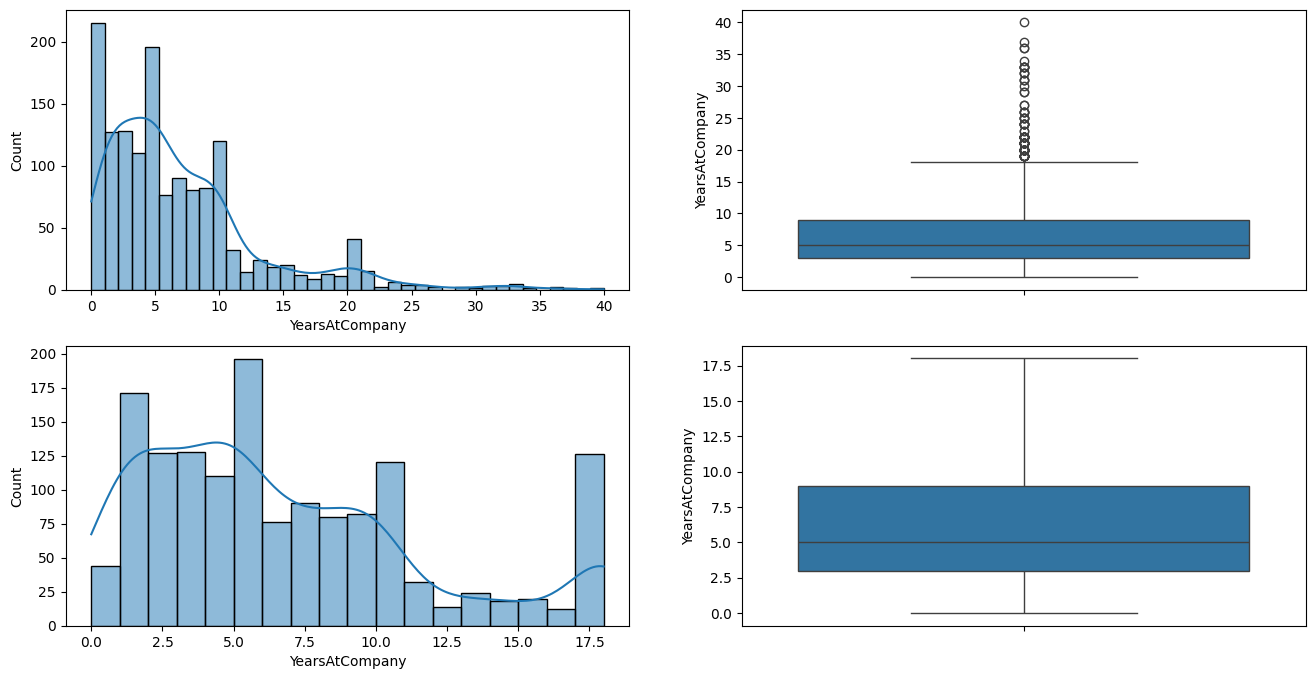

In [168]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(df['YearsAtCompany'], kde=True)
plt.subplot(2,2,2)
sns.boxplot(df['YearsAtCompany'])
plt.subplot(2,2,3)
sns.histplot(new_df['YearsAtCompany'], kde=True)
plt.subplot(2,2,4)
sns.boxplot(new_df['YearsAtCompany'])
plt.show()

* Vấn đề đối với các outlier: ở đây các dữ liệu đều là dữ liệu thực tế, tức là outlier có đại diện cho dữ liệu thực tế (ví dụ: số năm làm việc trong công ty trên 30 năm) chứ không phải phát sinh do lỗi dữ liệu. 
* Việc loại bỏ outlier có thể gây mất dữ liệu thực tế, mất mát hoặc làm sai lệch các thông tin quan trọng. Chẳng hạn như trên biểu đồ, một số lượng lớn nhân viên có chưa đầy 1 năm làm việc tại công ty được thay thế bằng số năm lớn hơn, điều này không phù hợp.

$\rightarrow$ Việc loại bỏ outlier sẽ được quyết định trong quá trình huấn luyện mô hình

### 5. Feature Engineering

#### 5.1. Label encoding

In [169]:
df_encoded = df.copy()
df_encoded.select_dtypes(exclude='number').columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [170]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [171]:
le = LabelEncoder()
for col in df_encoded.columns:
    le.fit(df_encoded[col])
    df_encoded[col] = le.transform(df_encoded[col])

In [172]:
df_encoded.select_dtypes(exclude='number').columns

Index([], dtype='object')

#### 5.2. Feature Scaling

* Chỉ có biến số tuổi gần với phân phối chuẩn --> Standard Scaling

* HourlyRate, DailyRate và MonthlyRate gần với phân phối đều --> MinMax Scaling

* Một số biến lệch phải như DistanceFromHome, MonthlyIncome, PercentSalaryHike, YearsAtCompany, TotalWorkingYear, YearsSinceLastPromotion --> log transformation

* Các biến còn lại --> Standard Scaling

In [173]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [174]:
scaled_df = df_encoded.copy()

In [175]:
for column in ['EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
               'RelationshipSatisfaction', 'WorkLifeBalance', 'StockOptionLevel']:
    mmscl = MinMaxScaler()
    scaled_df[column] = mmscl.fit_transform(scaled_df[[column]])

In [176]:
stdscl = StandardScaler()
scaled_df['Age'] = stdscl.fit_transform(scaled_df[['Age']])

In [177]:
for column in ['HourlyRate', 'DailyRate', 'MonthlyRate']:
    mmscl = MinMaxScaler()
    scaled_df[column] = mmscl.fit_transform(scaled_df[[column]])

In [178]:
for column in ['DistanceFromHome', 'MonthlyIncome', 'PercentSalaryHike', 
               'YearsAtCompany', 'TotalWorkingYears', 'YearsSinceLastPromotion']:
    scaled_df[column] = np.log1p(scaled_df[column])

In [179]:
for column in ['NumCompaniesWorked', 'TrainingTimesLastYear','YearsInCurrentRole', 'YearsWithCurrManager']:
    stdscl = StandardScaler()
    scaled_df[column] = stdscl.fit_transform(scaled_df[[column]])

In [180]:
for column in scaled_df.select_dtypes(include='number').columns:
    print(f"{column}: [{scaled_df[column].min()}, {scaled_df[column].max()}]")

Age: [-2.072192177156677, 2.526885578888087]
Attrition: [0, 1]
BusinessTravel: [0, 2]
DailyRate: [0.0, 1.0]
Department: [0, 2]
DistanceFromHome: [0.0, 3.367295829986474]
Education: [0, 4]
EducationField: [0, 5]
EmployeeCount: [0, 0]
EmployeeNumber: [0, 1469]
EnvironmentSatisfaction: [0.0, 1.0]
Gender: [0, 1]
HourlyRate: [0.0, 1.0]
JobInvolvement: [0.0, 1.0]
JobLevel: [0.0, 1.0]
JobRole: [0, 8]
JobSatisfaction: [0.0, 1.0]
MaritalStatus: [0, 2]
MonthlyIncome: [0.0, 7.207118856207756]
MonthlyRate: [0.0, 1.0]
NumCompaniesWorked: [-1.0785044383346125, 2.5255909693862573]
Over18: [0, 0]
OverTime: [0, 1]
PercentSalaryHike: [0.0, 2.70805020110221]
PerformanceRating: [0, 1]
RelationshipSatisfaction: [0.0, 1.0]
StandardHours: [0, 0]
StockOptionLevel: [0.0, 1.0]
TotalWorkingYears: [0.0, 3.6888794541139363]
TrainingTimesLastYear: [-2.171981830933257, 2.4833959938131165]
WorkLifeBalance: [0.0, 1.0]
YearsAtCompany: [0.0, 3.6109179126442243]
YearsInCurrentRole: [-1.1676872598353414, 3.802073862127523

#### 5.3. Imbalance Handling

Xử lý mất cân bằng giữa 2 class trong biến mục tiêu

In [181]:
from imblearn.over_sampling import SMOTE
features, target = scaled_df.drop('Attrition', axis=1), scaled_df['Attrition']
smote = SMOTE(sampling_strategy='auto', random_state=42)
features_resampled, target_resampled = smote.fit_resample(features, target)
features_resampled.shape

(2466, 34)

C:\Users\Duong\AppData\Local\Temp\ipykernel_10404\50946192.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = imb_values.index,
C:\Users\Duong\AppData\Local\Temp\ipykernel_10404\50946192.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = resampled_values.index,


Text(0, 0.5, 'Percentage')

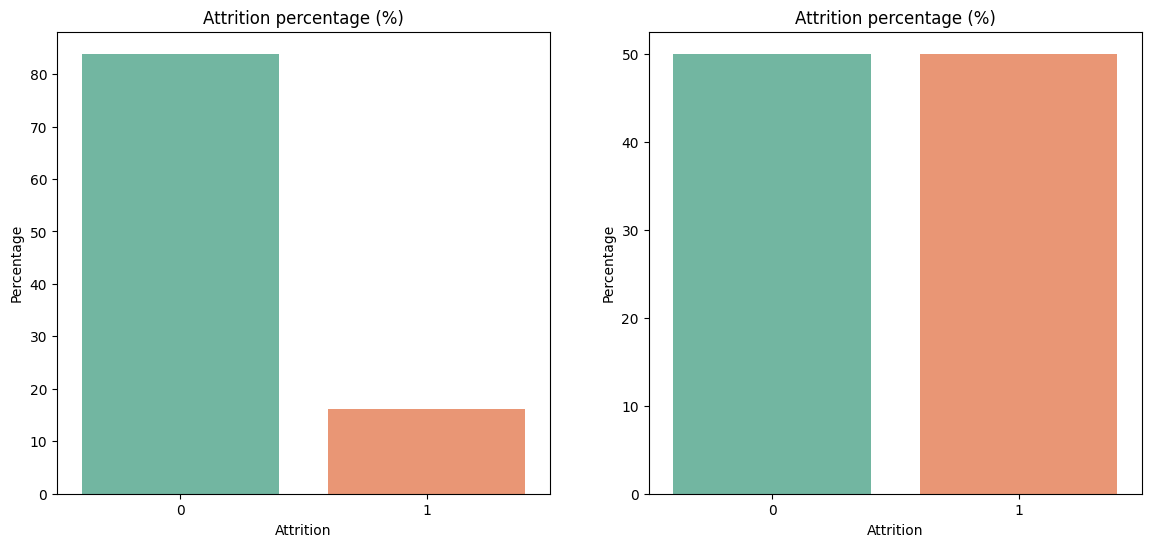

In [182]:
imb_values = scaled_df['Attrition'].value_counts()
resampled_values = target_resampled.value_counts()
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.barplot(x = imb_values.index,
            y = imb_values.values / sum(imb_values.values) * 100, palette="Set2")
plt.title('Attrition percentage (%)')
plt.ylabel('Percentage')
plt.subplot(1,2,2)
sns.barplot(x = resampled_values.index,
            y = resampled_values.values / sum(resampled_values.values) * 100, palette="Set2")
plt.title('Attrition percentage (%)')
plt.ylabel('Percentage')

In [183]:
new_df = pd.concat([features_resampled, target_resampled], axis=1)

In [184]:
# save data
import os
os.makedirs('Preprocessing/', exist_ok=True)
scaled_df.to_parquet('Preprocessing/imbalanced_df.parquet', index=False)        
new_df.to_parquet('Preprocessing/balanced_df.parquet', index=False)        

#### 5.2. Feature selection

Theo như phân tích EDA ban đầu, có 4 cột sẽ được loại bỏ vì không có ý nghĩa và ảnh hưởng đến biến mục tiêu:
* **Over18**, **EmployeeCount, StandardHours** chỉ chứa duy nhất 1 giá trị
* **EmployeeNumber** là mã số định danh của nhân viên trong công ty

In [185]:
new_df.drop(columns=['Over18','EmployeeCount','StandardHours','EmployeeNumber'], inplace=True)
new_df.shape

(2466, 31)

##### 5.2.1. Recursive Feature Elimination (RFE)

In [186]:
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [187]:
model = XGBClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv = RFECV(model, step = 1, cv = cv, scoring='accuracy')

features = new_df.drop('Attrition', axis=1)
target = target_resampled

rfecv.fit(features, target)

selected_features = features.columns[rfecv.support_]
feature_ranking = rfecv.ranking_  

rfe_features = features.columns[rfecv.support_]
print(f'Total number of selected features: {len(rfe_features)}')
for feature in rfe_features.to_list():
    print(feature)


Total number of selected features: 19
Age
BusinessTravel
EnvironmentSatisfaction
JobInvolvement
JobLevel
JobRole
JobSatisfaction
MonthlyIncome
NumCompaniesWorked
OverTime
RelationshipSatisfaction
StockOptionLevel
TotalWorkingYears
TrainingTimesLastYear
WorkLifeBalance
YearsAtCompany
YearsInCurrentRole
YearsSinceLastPromotion
YearsWithCurrManager


##### 5.2.2. Milticollinearity Elimination with VIF

In [188]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [189]:
def calculate_vif(df):
    vif = pd.DataFrame()
    vif['Feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

In [190]:
vif = calculate_vif(new_df)
vif[vif['VIF'] > 5]

,Feature,VIF
1,BusinessTravel,6.445515
3,Department,12.340227
10,JobInvolvement,6.823960
12,JobRole,8.368484
14,MaritalStatus,5.600512
15,MonthlyIncome,65.170931
19,PercentSalaryHike,5.748078
23,TotalWorkingYears,45.077876
25,WorkLifeBalance,7.105683
26,YearsAtCompany,32.903841


* Như vậy các biến MonthlyIncome, TotalWorkingYears và YearsAtCompany đang xảy ra hiện tượng đa cộng tuyến. Điều này khá hợp lý, vì khi số năm làm việc của một nhân viên càng cao thì khả năng nhân viên đó làm việc lâu năm ở công ty cao hơn, đồng thời số năm làm việc cao cũng có thể nhận được mức thu nhập cao hơn

* Biến Department cũng có chỉ số VIF cao, cho thấy tính chất đa cộng tuyến của nó với các biến khác

In [191]:
truncated_df = new_df.drop('Attrition', axis=1).copy()
vif_removed_columns = []

while True:
    vif_df = calculate_vif(truncated_df)
    vif_threshold = 5  
    max_vif = vif_df['VIF'].max()
    
    if max_vif < vif_threshold:
        break
    
    vif_df.sort_values('VIF', ascending=False, inplace=True)
    
    removed_feature = vif_df.iloc[0]['Feature']
    
    truncated_df = truncated_df.drop(columns=[removed_feature])
    
    print(f'Removed column {removed_feature} with VIF {max_vif}')
    vif_removed_columns.append(removed_feature)

Removed column MonthlyIncome with VIF 64.49479697954844
Removed column TotalWorkingYears with VIF 36.162578061398655
Removed column YearsAtCompany with VIF 21.623209217153317
Removed column Department with VIF 11.676005702067513
Removed column WorkLifeBalance with VIF 6.750778081743219
Removed column JobInvolvement with VIF 6.438823502816959
Removed column BusinessTravel with VIF 5.943946825502331
Removed column PercentSalaryHike with VIF 5.411508683724476


In [192]:
vif_features = truncated_df.columns
print(f'Total number of selected features: {len(vif_features)}')
for feature in vif_features:
    print(feature)

Total number of selected features: 22
Age
DailyRate
DistanceFromHome
Education
EducationField
EnvironmentSatisfaction
Gender
HourlyRate
JobLevel
JobRole
JobSatisfaction
MaritalStatus
MonthlyRate
NumCompaniesWorked
OverTime
PerformanceRating
RelationshipSatisfaction
StockOptionLevel
TrainingTimesLastYear
YearsInCurrentRole
YearsSinceLastPromotion
YearsWithCurrManager


##### 5.2.3. Dimensionality Reduction with PCA

<Axes: >

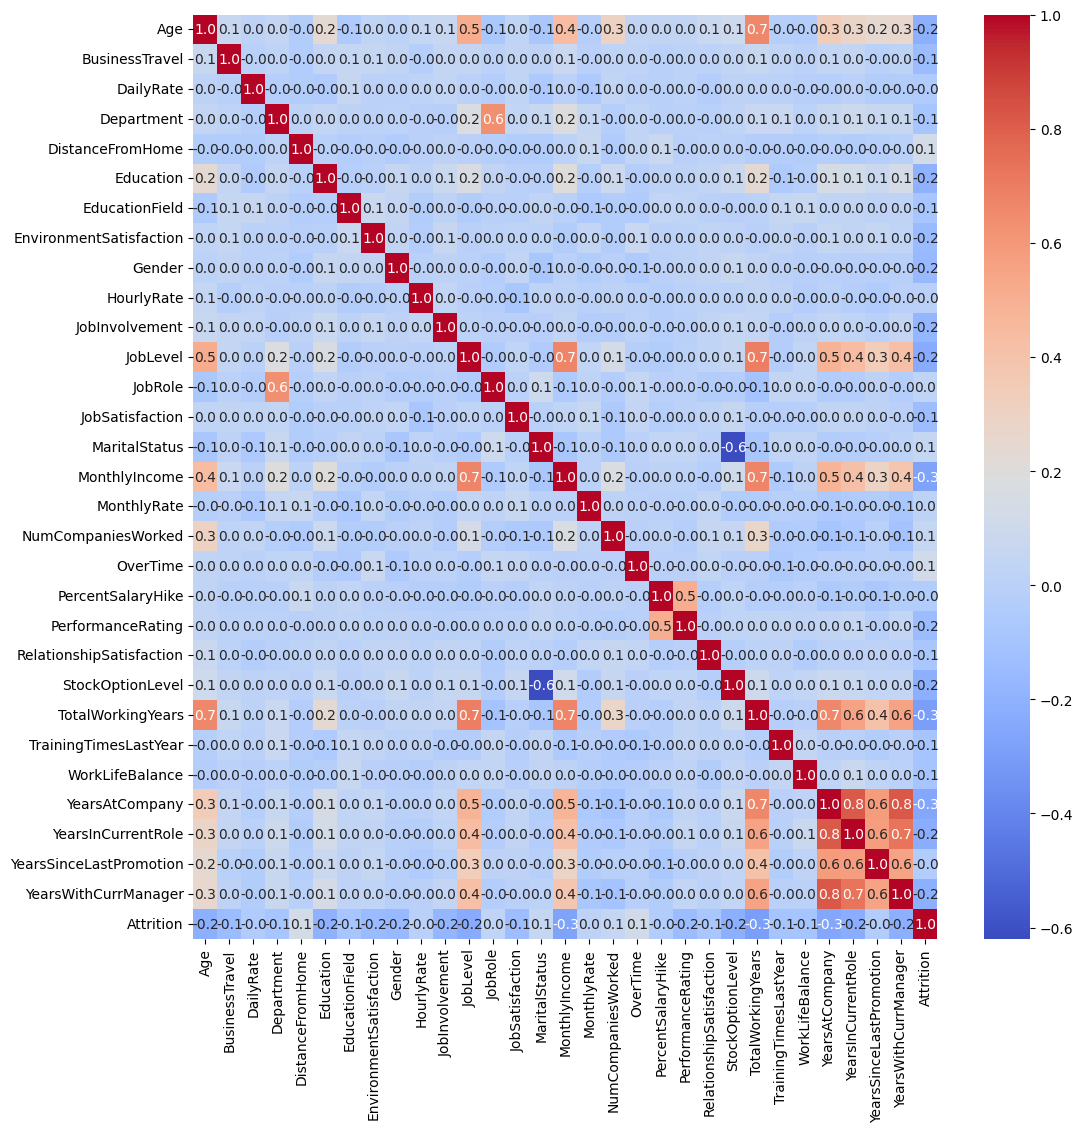

In [193]:
plt.figure(figsize=(12,12))
sns.heatmap(new_df.corr(), annot=True, cmap='coolwarm', fmt='.1f')

In [194]:
from sklearn.decomposition import PCA

In [195]:
pca = PCA()
features_df = new_df.drop('Attrition', axis=1)
pca_df = pca.fit_transform(features_df)

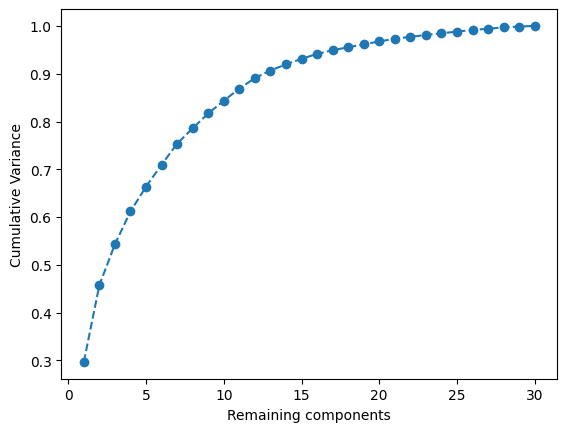

In [196]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Remaining components')
plt.ylabel('Cumulative Variance')
plt.show()

In [197]:
pca_threshold = 0.97

num_components = np.argmax(explained_variance >= pca_threshold) + 1  
final_data = pca_df[:, :num_components]

print(f"Remaining {num_components} features")

Remaining 21 features


In [198]:
loadings = pd.DataFrame(pca.components_[:num_components], columns=features_df.columns, index=[f'PC{i+1}' for i in range(num_components)])
print("PCA loading matrix")
loadings

PCA loading matrix


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
PC1,-0.045894,-0.000237,-0.003358,0.140031,-0.008948,0.009017,0.000206,0.001062,-0.006518,-0.002808,...,0.000357,-0.004932,-0.004110,-0.044512,0.023623,0.003768,-0.025633,-0.024832,-0.003262,-0.025073
PC2,0.331923,0.029240,-0.001979,0.059370,-0.022256,0.183998,0.005656,0.005132,0.001415,0.001125,...,0.006686,0.003377,0.017454,0.332988,-0.020660,0.003163,0.355968,0.414389,0.274200,0.411370
PC3,-0.142712,0.027244,0.011065,0.003163,-0.048637,-0.091846,0.945840,0.025092,0.016267,-0.010181,...,0.011103,-0.002813,-0.007177,-0.035774,0.102627,0.015795,0.067440,0.093494,0.049819,0.092127
PC4,0.380015,0.052134,0.011772,0.018226,-0.076589,0.297535,0.295071,-0.005555,0.027290,0.007709,...,0.005276,0.017693,0.022042,0.137494,-0.066158,-0.006371,-0.211241,-0.278209,-0.181018,-0.311626
PC5,-0.021127,-0.038132,-0.009174,0.017145,0.934605,0.137964,0.080849,-0.008318,-0.014525,-0.003193,...,0.020083,-0.000026,0.008745,-0.005247,-0.225434,-0.008504,-0.016231,-0.032185,-0.032181,-0.009314
PC6,-0.141563,0.010466,-0.013826,-0.042040,-0.232830,0.786125,0.015765,-0.001663,0.039942,-0.003374,...,-0.000101,-0.002292,-0.005460,-0.101533,-0.422055,-0.004590,-0.000520,0.000685,-0.014437,0.033849
PC7,0.056225,0.044340,-0.008820,0.019416,0.135372,0.440379,-0.060779,0.009408,0.019594,0.008374,...,0.016631,0.011944,0.009734,-0.003744,0.859489,0.004341,-0.010742,-0.042864,-0.081773,-0.007856
PC8,0.038831,0.095369,0.002368,0.104499,-0.175692,-0.132585,-0.027930,-0.011875,0.017611,0.004920,...,0.101472,-0.036856,0.001313,0.035356,-0.022470,0.009215,-0.066166,-0.137714,-0.266237,-0.162522
PC9,0.092254,-0.058625,-0.010711,-0.069559,-0.056798,0.000624,-0.045926,0.013344,-0.039126,-0.004886,...,0.197887,0.008180,-0.059677,-0.025114,0.011599,0.001300,0.037506,0.112145,0.086072,0.139066
PC10,-0.430572,0.057002,-0.022325,0.047809,0.044535,0.063249,-0.022730,-0.027792,-0.090191,0.003501,...,-0.039112,-0.014743,-0.190441,-0.004763,0.019606,0.009034,-0.020675,-0.008606,-0.030007,0.040895


In [199]:
importance = np.sum(np.abs(loadings), axis=0)
importance_df = pd.DataFrame({'Feature': features_df.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.reset_index(drop=True)

,Feature,Importance
0,MonthlyIncome,3.388719
1,YearsWithCurrManager,3.113483
2,NumCompaniesWorked,3.059933
3,Age,3.053466
4,TotalWorkingYears,2.779987
5,YearsInCurrentRole,2.687618
6,Education,2.429008
7,Department,2.424609
8,EnvironmentSatisfaction,2.290809
9,YearsSinceLastPromotion,2.246342


In [200]:
pca_features = importance_df['Feature'].iloc[:num_components]
print(f'Total number of selected features: {len(pca_features)}')
for feature in pca_features:
    print(feature)

Total number of selected features: 21
MonthlyIncome
YearsWithCurrManager
NumCompaniesWorked
Age
TotalWorkingYears
YearsInCurrentRole
Education
Department
EnvironmentSatisfaction
YearsSinceLastPromotion
MaritalStatus
RelationshipSatisfaction
PercentSalaryHike
TrainingTimesLastYear
JobSatisfaction
DistanceFromHome
Gender
YearsAtCompany
BusinessTravel
OverTime
EducationField


##### 5.2.4. Final Selection

In [201]:
selected_features_df = pd.DataFrame()

In [202]:
def make_column(all_features, selected_features):
    col = []
    for feature in all_features:
        if feature in selected_features:
            col.append(1)
        else:
            col.append(0)
    return col

In [203]:
rfe_col = make_column(features_df.columns, rfe_features)
pca_col = make_column(features_df.columns, pca_features)
vif_col = make_column(features_df.columns, vif_features)

selected_features_df['RFE'] = rfe_col
selected_features_df['VIF'] = vif_col
selected_features_df['PCA'] = pca_col
selected_features_df.index = features_df.columns

In [204]:
selected_features_df

,RFE,VIF,PCA
Age,1,1,1
BusinessTravel,1,0,1
DailyRate,0,1,0
Department,0,0,1
DistanceFromHome,0,1,1
Education,0,1,1
EducationField,0,1,1
EnvironmentSatisfaction,1,1,1
Gender,0,1,1
HourlyRate,0,1,0


In [205]:
selected_features = set(rfe_features) & set(vif_features) & set(pca_features)   # Get common features

In [206]:
selected_features.update([
    'BusinessTravel',
    'DistanceFromHome',
    'Education',
    'EducationField',
    'JobLevel',
    'JobRole',
    'StockOptionLevel',
    'TotalWorkingYears'
])

In [207]:
for feature in selected_features:
    print(feature)

Education
JobLevel
EducationField
StockOptionLevel
DistanceFromHome
RelationshipSatisfaction
EnvironmentSatisfaction
YearsInCurrentRole
TrainingTimesLastYear
YearsSinceLastPromotion
OverTime
NumCompaniesWorked
BusinessTravel
YearsWithCurrManager
TotalWorkingYears
Age
JobSatisfaction
JobRole


In [208]:
selected_features_df['Final'] = vif_col = make_column(features_df.columns, selected_features)

In [210]:
selected_features_df.to_parquet('Preprocessing/Selected_features.parquet', index=True)